In [1]:
import os
import numpy as np
import pandas as pd
import lancet
import holoviews as hv

from featuremapper.analysis.raster import fft_power
from featuremapper.analysis.pinwheels import PinwheelAnalysis
from featuremapper.analysis.hypercolumns import PowerSpectrumAnalysis
from topo.analysis.command import *
from analysis import *

import topo
from topo.analysis import Collector
from topo.submodel.scal import ModelSCAL
from topo.submodel.gcal import ArraySpec

from topo.command import runscript  # In order to check the model files load correctly
from topo.misc.lancext import RunBatchCommand, topo_metadata

hv.notebook_extension()

# Experimental Setup

### Defining the parameter space

In [2]:
batch_name = 'SCAL_spatial'

# Model options
laterals = True

# Measurements
rfs = True
isosuppression = True
sizetuning = True
frequencytuning = True
complexity = False
flankers = True

# Define times
times = [1000*i for i in range(21)]
print("Collection times start at %s and end at %s" % (min(times), max(times)))

# Define Args
constants = lancet.Args(area=4.0, aff_strength=2.4, exc_strength=1.6, inh_strength=1.8,
                        cortex_density=47, lgn_density=16, laterals=laterals, t_settle=16,)
batch_arguments = constants * lancet.Args(times=times) * lancet.List('dataset', ['Gaussian', 'natural', 'treeshrew'])

Collection times start at 0 and end at 20000


### Loading the model

In [9]:
topo.sim.model = ModelSCAL(laterals=laterals, area=1.0)
scal = topo.sim.model.specification
topo.sim.model()

ModelSCAL

Retina : GeneratorSheet

LGNOn : SettlingCFSheet
   LGNOn.Afferent [Retina -> LGNOn] : SharedWeightCFProjection
   LGNOn.LateralGC [LGNOn -> LGNOn] : SharedWeightCFProjection

LGNOff : SettlingCFSheet
   LGNOff.Afferent [Retina -> LGNOff] : SharedWeightCFProjection
   LGNOff.LateralGC [LGNOff -> LGNOff] : SharedWeightCFProjection

V1 : SettlingCFSheet
   V1.LGNOffAfferent [LGNOff -> V1] : CFProjection
   V1.LGNOnAfferent [LGNOn -> V1] : CFProjection
   V1.LRExcitatory [V1 -> V1] : CFProjection
   V1.LateralExcitatory [V1 -> V1] : CFProjection
   V1.LateralInhibitory [V1 -> V1] : CFProjection


### Defining the measurements and analysis

In [10]:
c = Collector()

# Projection activities
c.Activity.LGNOnAfferent =  c.collect(scal.projections.V1.LGNOnAfferent)
c.Activity.LGNOffAfferent = c.collect(scal.projections.V1.LGNOffAfferent)

# OR preference measurement
c.collect(measure_or_pref)
# Sheet activities
c.Activity.Retina =         c.collect(scal.sheets.Retina)
c.Activity.V1 =             c.collect(scal.sheets.V1)
# Connection fields
c.CFs.LGNOnAfferent =       c.collect(scal.projections.V1.LGNOnAfferent,  grid=True)
c.CFs.LGNOffAfferent =      c.collect(scal.projections.V1.LGNOffAfferent, grid=True)
c.CFs.LateralInhibitory =   c.collect(scal.projections.V1.LateralInhibitory, grid=True)
c.CFs.LateralExcitatory =   c.collect(scal.projections.V1.LateralExcitatory, grid=True)
if laterals:
    c.CFs.LRExcitatory =   c.collect(scal.projections.V1.LRExcitatory, rows=47, cols=47,
                                     grid=True, bounds=(-.5, -.5, .5, .5))

# Homeostatic threshold
c.HomeostaticThreshold.V1 = c.collect(ArraySpec('V1.output_fns[0].t'), 
                                                group='Homeostatic Threshold')

# OR preference measurement
c.collect(measure_or_pref, frequencies=[1.4, 1.6, 1.8], num_orientation=8)
c.collect(measure_response, durations=list(np.linspace(0, 1, 21)))
c.collect(measure_or_tuning_fullfield, contrasts=[10, 30, 50, 70, 100],
          frequencies=[1.6, 1.8], times=[times[-1]])

if rfs:
    c.collect(measure_rfs, roi=(-.25, -.25, .25, .25), presentations=5000, scale=100, outputs=['V1'], times=[times[-1]])

# Times and coords for further measurements
coords=[(0,-0.1),(-0.1,0.0),(0,0),(0,0.1),(0.1,0.0)]
frequency=1.6

# Analysis
c.Pinwheels.V1   = c.analyze(c.ref.OrientationPreference.V1[:, -1.5:1.5, -1.5:1.5]
                             * c.ref.OrientationSelectivity.V1[:, -1.5:1.5, -1.5:1.5], PinwheelAnalysis)
c.FFTAnalysis.V1 = c.analyze(c.ref.OrientationPreference.V1[:, -1.5:1.5, -1.5:1.5], PowerSpectrumAnalysis)

# Measure position preference, requisite for other measurements
if sizetuning or frequencytuning or flankers or complexity or isosuppression:
    c.collect(measure_position_pref, x_range=(-0.4,0.4), y_range=(-0.4,0.4),
              size=0.1, outputs=['V1'], divisions=36, scale=2.0)

# Orientation Contrast Suppression
if isosuppression:
    c.analyze(c.ref.OrientationPreference.V1, measure_iso_suppression, output='V1',
              frequency=frequency, contrastcenter=[10, 70], contrastsurround=[10, 30, 70, 100],
              times=[times[-1]], mode='merge', coords=coords, relative_roi=(-0.5, -0.5, 0.5, 0.5), num_orientation=11)

# Size Tuning Analysis
if sizetuning:
    c.analyze(c.ref.OrientationPreference.V1, measure_size_tuning, num_phase=8, outputs=['V1'],
              coords=coords, frequency=frequency, contrasts=[10, 70, 100], times=[times[-1]], mode='merge')

# Measure PhaseTuning and Complexity
if complexity:
    c.analyze(c.ref.OrientationPreference.V1, measure_phase_tuning, outputs=['V1'], frequencies=[frequency],
              num_orientation=12, times=times, mode='merge')
    c.analyze(c.ref.PhaseTuning.V1, ComplexityAnalysis, times=[times[-1]], mode='merge')

# Measure flanker modulation
if flankers:
    c.collect(measure_flanker_ormodulation, coords=coords, outputs=['V1'], times=[times[-1]])
    c.collect(measure_flanker_xoffsetmodulation, coords=coords, outputs=['V1'], times=[times[-1]])
    c.collect(measure_flanker_yoffsetmodulation, coords=coords, outputs=['V1'], times=[times[-1]])

### Launching the jobs

In [11]:
# Local or on cluster
QSUB = True
# Open diff in pager or not
SHOW_DIFF = True

ty_file = './scal_divisive.ty'
metadata = topo_metadata()
output_directory = os.path.join(os.getcwd(), 'data')

lancet.review_and_launch.output_directory = output_directory

qsub_options = dict(b='y',
                    l='h_vmem=2G',      # Allocate 2GB per core
                    pe=('sharedmem', '6'),   # Parallel environment allocation
                    v='OMP_NUM_THREADS=6')   # Must match slot allocation above.

@lancet.review_and_launch()
def launch():
    runbatch_cmd = RunBatchCommand(ty_file, c, metadata=batch_arguments.varying_keys)
    Launcher = lancet.QLauncher if QSUB else lancet.Launcher
    return Launcher(batch_name, batch_arguments, runbatch_cmd,  metadata=metadata(), 
                    **({'qsub_flag_options':qsub_options} if QSUB else {'max_concurrency': 3}))
launch()


| Arguments Summary |

Items: 3
Varying Keys: 'dataset'
Constant Items: aff_strength=2.4, area=4.0, cortex_density=47, exc_strength=1.6, inh_strength=1.8, laterals=True, lgn_density=16, t_settle=16, times=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000]

Show available argument specifier entries? [y, N, quit]: 

| RunBatchCommand Summary |

Command executable: /exports/eddie/scratch/s1048519/topographica/topographica
Collector definition summary:

23 tasks scheduled:

  01.  Activity.LGNOnAfferent
           ProjectionSpec
  02.  Activity.LGNOffAfferent
           ProjectionSpec
  03.  [...] 
          measure_or_pref
  04.  Activity.Retina
           SheetSpec
  05.  Activity.V1
           SheetSpec
  06.  CFs.LGNOnAfferent
           ProjectionSpec [grid=True]
  07.  CFs.LGNOffAfferent
           ProjectionSpec [grid=True]
  08.  CFs.LateralInhibitory
           ProjectionSpec [grid=True]
  09.  CF

Time: 000000.00 QLauncher: Invoked qsub for 3 commands


True

# Monitoring Progress

In [3]:
from holoviews.core.io import Unpickler
from analysis.progress import ProgressWidget, load_table
hv.notebook_extension('bokeh')

In [4]:
path = './data/2016-05-03_1326-SCAL_spatial'
table = load_table(path)
data = Unpickler.collect(table, drop=['time', 'Index', 'tid', 'timestamps'])
ProgressWidget(path)

:Layout
   .DynamicMap.I   :DynamicMap   [Time]
   .DynamicMap.II  :DynamicMap   [Time]
   .DynamicMap.III :DynamicMap   [Time]
   .DynamicMap.IV  :DynamicMap   [Time]

# Results and Analysis

In [9]:
from topo.command import load_snapshot
hv.notebook_extension('matplotlib')
from topo.base.simulation import EPConnectionEvent

In [5]:
load_snapshot("./data/2016-04-26_1610-SCAL_spatial/2016-04-26_1610_scal_divisive_t0_dataset='Gaussian'/2016-04-26_1610_scal_divisive_t0__020000.00.typ")

clear_fn restored from bytecode into __main__


Time: 000000.00 PowerSpectrumAnalysis: Slicing data to nearest odd dimensions for centered FFT.


:Layout
   .PinwheelAnalysis.V1        :HoloMap   [Index,Frame]
      :Overlay
         .Orientation_Preference.V1 :Image   [x,y]   (Orientation Preference)
         .Real.V1                   :Contours   [x,y]
         .Imaginary.V1              :Contours   [x,y]
         .Pinwheels.V1              :Points   [x,y]
   .FFT_Power.V1               :HoloMap   [Index,Frame]
      :Image   [x,y]   (z)
   .PowerFit.V1                :HoloMap   [Index,Frame]
      :Overlay
         .FFTPowerHistogram.V1 :Histogram   [Wavenumber]   (Frequency)
         .FFTPowerFit.V1       :Curve   [Wavenumber]   (y)
         .KMax.V1              :VLine   [x,y]
   .PowerSpectrum_Analysis.V1  :HoloMap   [Index,Frame]
      :ItemTable   (cycles,k_delta,kmax,rho,rho_metric,units_per_hc)
   .Orientation_Selectivity.V1 :Histogram   [Orientation Selectivity]   (Frequency)
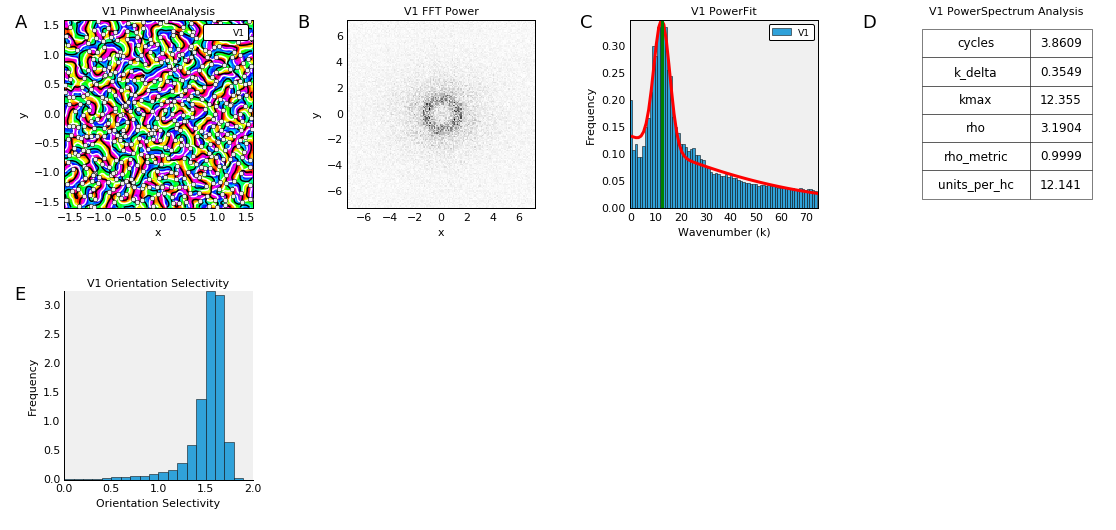

In [10]:
import os
mode = 'rb' if os.path.isfile('SCAL_OR.hvz') else 'wb'
with open('SCAL_OR.hvz', mode) as f:
    if mode == 'rb':
        orpreference = hv.Store.load(f)
    else:
        orpreference = measure_or_pref(frequencies=[1.5], num_orientation=8)
        hv.Store.dump(orpreference, f, protocol=2)
PowerSpectrumAnalysis(orpreference.OrientationPreference.V1.last[-1.6:1.6, -1.6:1.6]).display('all') +\
orpreference.OrientationSelectivity.V1.last.hist(adjoin=False)

## LGN Spatial Tuning

### Size tuning

In [241]:
from featuremapper.analysis.spatialtuning import Size_DivDoGModel, Size_iDoGModel, SizeTuningPeaks

The tuning properties of the LGN can be confirmed very quickly, instead of scheduling it as part of the global measurement, we will simply measure the size and frequency response of the typical LGN neuron directly.

In [33]:
lgn_tuning = measure_size_response(outputs=['LGNOn'], num_sizes=31, max_size=3,
                                   contrasts=range(10, 110, 10), durations=[0.15])

Here are the stereotyped size tuning curves for the LGN On layer depending on the contrast level:

In [34]:
%%output fig='svg' filename='LGN_SizeTuning'
%%opts NdOverlay [fig_size=200 aspect=1.5 legend_cols=2 bgcolor='w'] Curve (color=Palette('Greys')[.2:])
lgn_tuning.SizeTuning.LGNOn.sample([(0,0)]).to.curve(['Size'], ['Response']).overlay('Contrast')

:HoloMap   [X,Y,Time,Duration,x,y]
   :NdOverlay   [Contrast]
      :Curve   [Size]   (Response)

Next we can fit these curves with a divisive and subtractive integrated Difference of Gaussian model introduced by Sceniak et al. (2006). For a brief summary of how this model works view the [iDoG Model](../Methods/iDoG_Model.ipynb) notebook.

In [35]:
lgn_size_curve = lgn_tuning.SizeTuning.LGNOn.reindex().sample([(0,0)]).to.curve(['Size'], ['Response'])

# Divisive DoG Model
div_size_fit = Size_DivDoGModel(lgn_size_curve, max_iterations=10**7).collate()

# Integrated DoG Model
sub_size_fit = Size_iDoGModel(lgn_size_curve).collate()

# Simple argmin, argmax fit
size_est = SizeTuningPeaks(lgn_size_curve)

#### Divisive Fit

Viewing this fit we can see that it performs well for low contrasts but fails to provide a good match at higher contrast levels.

:Layout
   .Overlay.I                :HoloMap   [Contrast,x,y]
      :Overlay
         .SizeTuning_Response.I    :Curve   [Size]   (Response)
         .Response.Size_Tuning_Fit :Curve   [Size]   (Response)
   .ItemTable.IDoG_Model_Fit :HoloMap   [Contrast,x,y]
      :ItemTable   (a,b,K_s,SI,K_c,$r^2$,MSE)
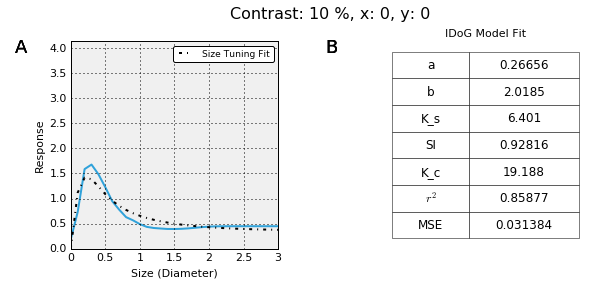
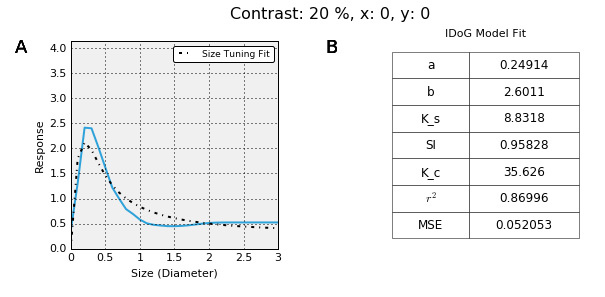
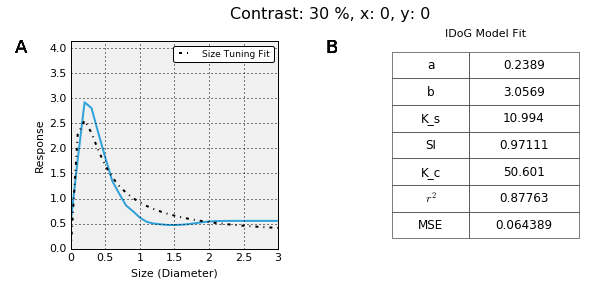
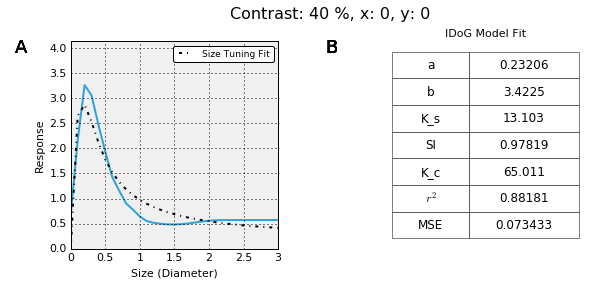
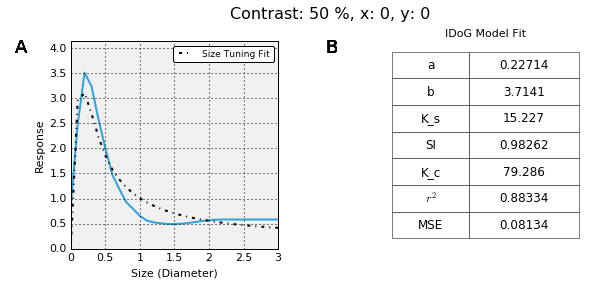
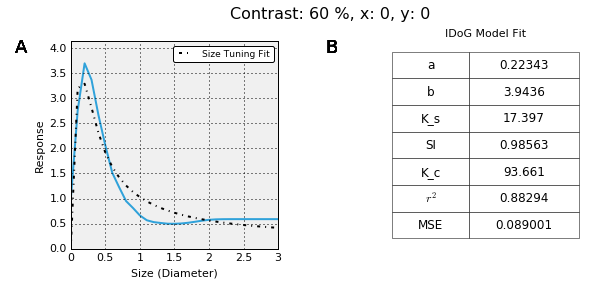
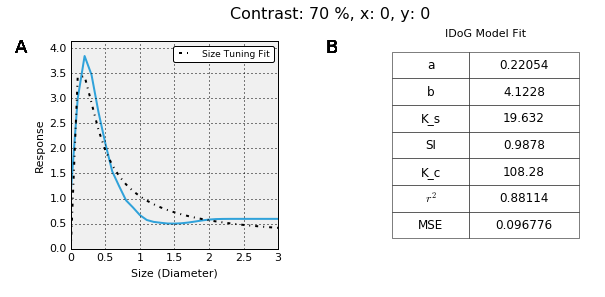
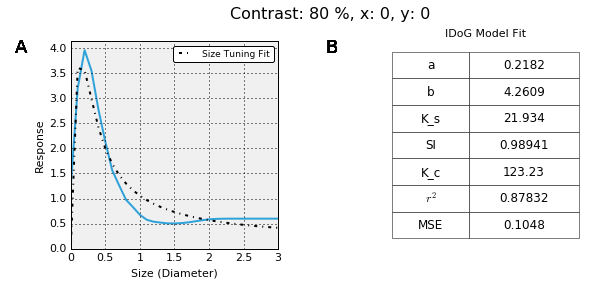
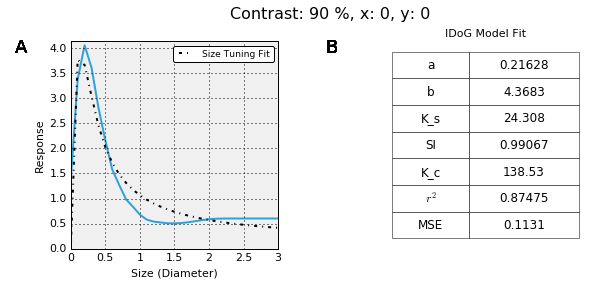
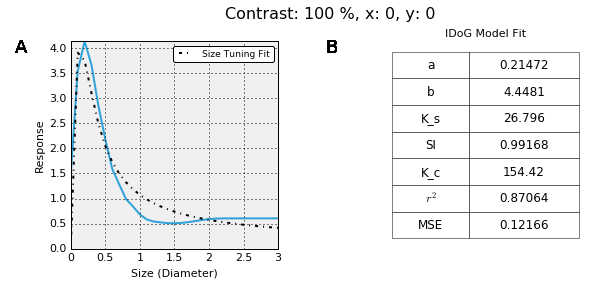

In [36]:
div_size_fit

#### Subtractive Fit

In contrast the subtractive integrated Difference-of-Gaussian model provides a good fit for the data throughout:

:Layout
   .Overlay.I                :HoloMap   [Contrast,x,y]
      :Overlay
         .SizeTuning_Response.I    :Curve   [Size]   (Response)
         .Response.Size_Tuning_Fit :Curve   [Size]   (Response)
   .ItemTable.IDoG_Model_Fit :HoloMap   [Contrast,x,y]
      :ItemTable   (a,b,K_s,SI,K_c,$r^2$,MSE)
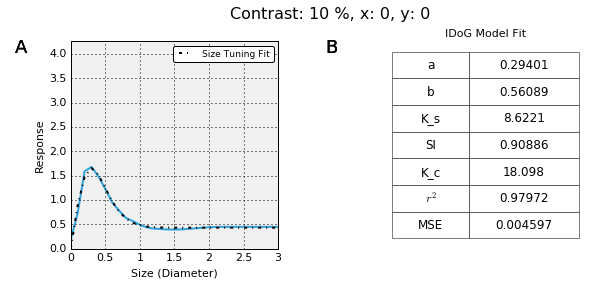
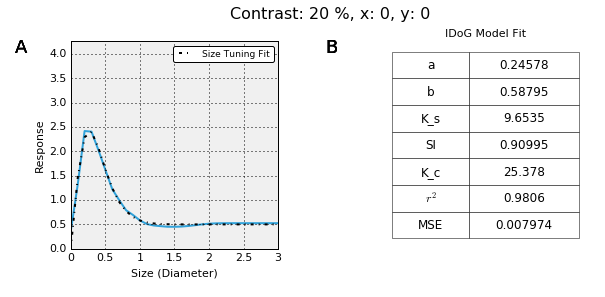
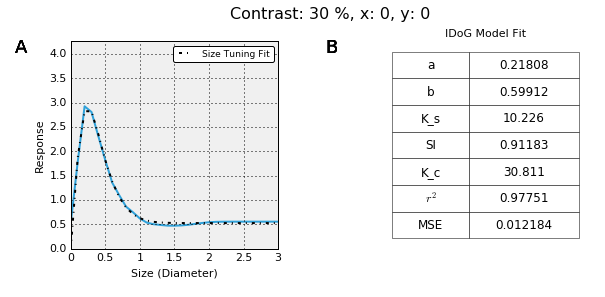
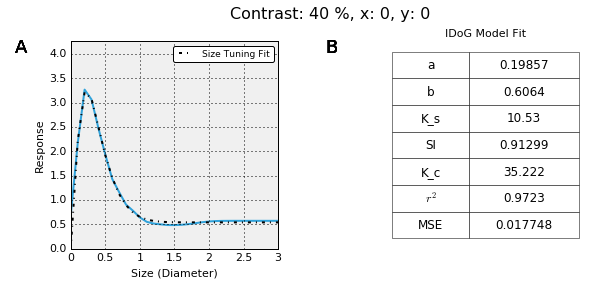
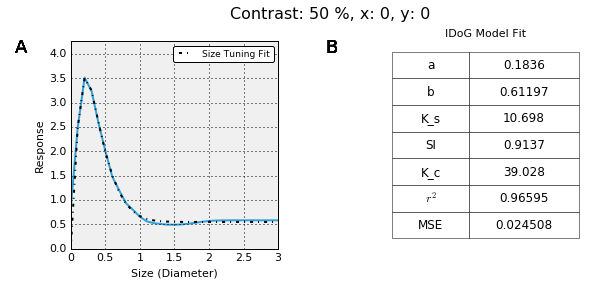
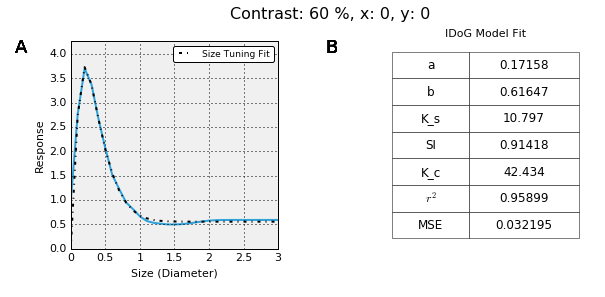
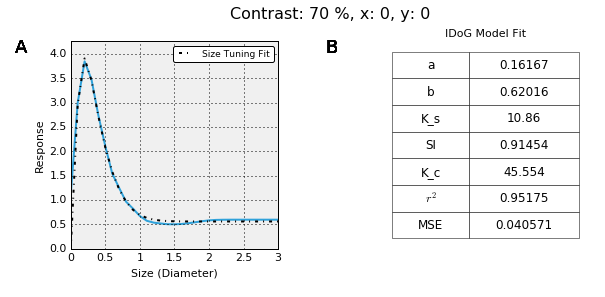
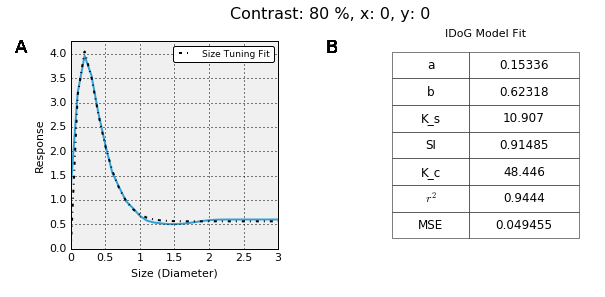
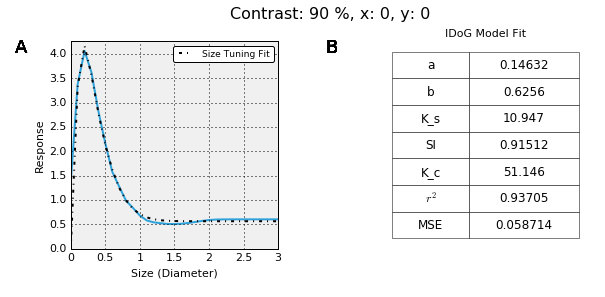
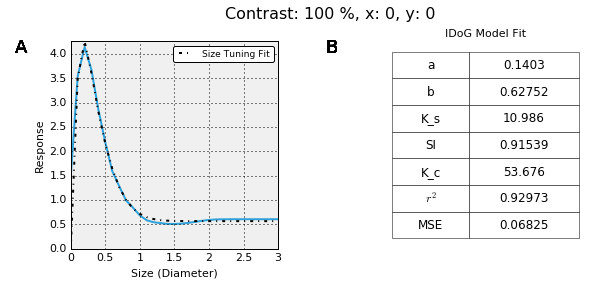

In [37]:
sub_size_fit

### Model Evaluation

In [119]:
%%output fig='svg' filename='LGN_DoG'
%%opts BoxWhisker [bgcolor='w'] Overlay [bgcolor='w' legend_position='top'] Curve (linewidth=3)
model_fits = hv.HoloMap({'Subtractive': sub_size_fit.ItemTable.IDoG_Model_Fit,
                         'Divisive': div_size_fit.ItemTable.IDoG_Model_Fit}, kdims=['Model']).table()
low_contrast = sub_size_fit.Overlay.I[30, 0, 0]
low_contrast.SizeTuning_Response.I(style=dict(color='gray')) *\
low_contrast.Response.Size_Tuning_Fit.relabel('Subtractive')(style=dict(color='indianred', linestyle='-.')) *\
div_size_fit.Overlay.I[30, 0, 0].Response.Size_Tuning_Fit.relabel('Divisive')(style=dict(color='SteelBlue', linestyle='-.')) +\
model_fits.to.box('Model', '$r^2$', []).relabel(group='Explained variance')

:Layout
   .Overlay.I            :Overlay
      .SizeTuning_Response.I :Curve   [Size]   (Response)
      .Response.Subtractive  :Curve   [Size]   (Response)
      .Response.Divisive     :Curve   [Size]   (Response)
   .Explained_variance.I :BoxWhisker   [Model]   ($r^2$)

In [482]:
print model_fits.select(Model='Divisive')['$r^2$'].mean(), model_fits.select(Model='Subtractive')['$r^2$'].mean()

0.875931607859 0.959800724922


#### Comparing simple estimation to fit

:Layout
   .Overlay.I  :Overlay
      .Curve.I  :Curve   [Contrast]   (Peak Size)
      .Curve.II :Curve   [Contrast]   (a)
   .Overlay.II :Overlay
      .Curve.I  :Curve   [Contrast]   (Suppression Size)
      .Curve.II :Curve   [Contrast]   (b)
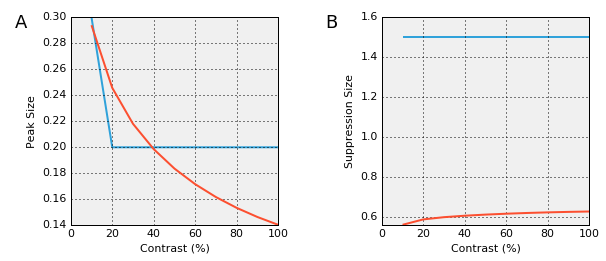

In [80]:
(size_est.table().to.curve(['Contrast'], ['Peak Size'], [])
 * sub_size_fit.ItemTable.IDoG_Model_Fit.table().to.curve(['Contrast'], ['a'], [])) +\
(size_est.table().to.curve(['Contrast'], ['Suppression Size'], [])
 * sub_size_fit.ItemTable.IDoG_Model_Fit.table().to.curve(['Contrast'], ['b'], []))[:, :1.6]

### Frequency Tuning

In [106]:
freq_response = measure_frequency_response(outputs=['LGNOn'],num_freq=26, max_freq=5,
                                           contrasts=range(10, 110, 10), size=2, durations=[0.15])

In [509]:
def logx(plot, element):
    ax = plot.handles['axis']
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([0.01, 1])
    ax.set_xlim([0.1,6])
    ax.tick_params('both', length=4, width=0.5, which='minor')
    ax.tick_params('both', length=8, width=0.5, which='major')
    ax.xaxis.set_ticks([0.1, 1, 5])
    ax.xaxis.set_ticklabels([0.1, 1, 5])
    ax.yaxis.set_ticks([0.01, 0.1, 0.1, 1])
    ax.yaxis.set_ticklabels([0.01, 0.1, 0.1, 1])
    ax.set_aspect(0.7)

In [360]:
str(hv.__version__)

'1.4.3-337-gebf9460-dirty'

In [510]:
%%output fig='svg' filename='LGN_FrequencyTuning' size=80
%%opts NdOverlay [fig_size=200 aspect=2 legend_cols=5 aspect='square' legend_position='bottom' bgcolor='w' final_hooks=[logx]] 
%%opts Curve (color=Palette('Greys')[.2:])

freq_tuning = freq_response.FrequencyTuning.LGNOn.reindex().sample([(0,0)]).to.curve(['Frequency'], ['Response'])
freq_tuning.overlay('Contrast').relabel(group='Frequency Tuning', label='LGN')

:HoloMap   [x,y]
   :NdOverlay   [Contrast]
      :Curve   [Frequency]   (Response)

## Pinwheel Analysis

Time: 020000.00 PowerSpectrumAnalysis: Slicing data to nearest odd dimensions for centered FFT.
Time: 020000.00 PowerSpectrumAnalysis: Slicing data to nearest odd dimensions for centered FFT.
Time: 020000.00 PowerSpectrumAnalysis: Slicing data to nearest odd dimensions for centered FFT.


:Layout
   .PinwheelAnalysis.V1       :HoloMap   [dataset]
      :Overlay
         .Orientation_Preference.V1 :Image   [x,y]   (Orientation Preference)
         .Real.V1                   :Contours   [x,y]
         .Imaginary.V1              :Contours   [x,y]
         .Pinwheels.V1              :Points   [x,y]
   .FFT_Power.V1              :HoloMap   [dataset]
      :Image   [x,y]   (z)
   .PowerFit.V1               :HoloMap   [dataset]
      :Overlay
         .FFTPowerHistogram.V1 :Histogram   [Wavenumber]   (Frequency)
         .FFTPowerFit.V1       :Curve   [Wavenumber]   (y)
         .KMax.V1              :VLine   [x,y]
   .PowerSpectrum_Analysis.V1 :HoloMap   [dataset]
      :ItemTable   (cycles,k_delta,kmax,rho,rho_metric,units_per_hc)
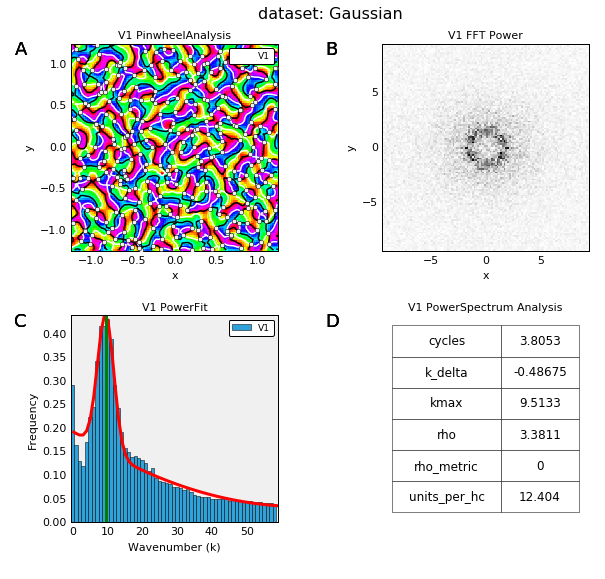
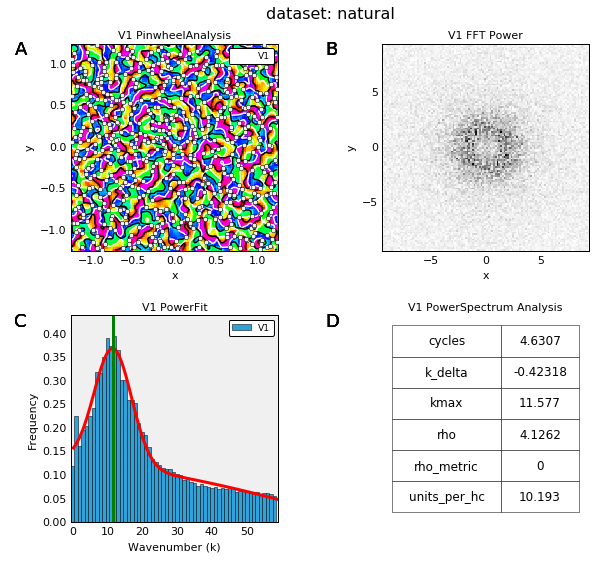
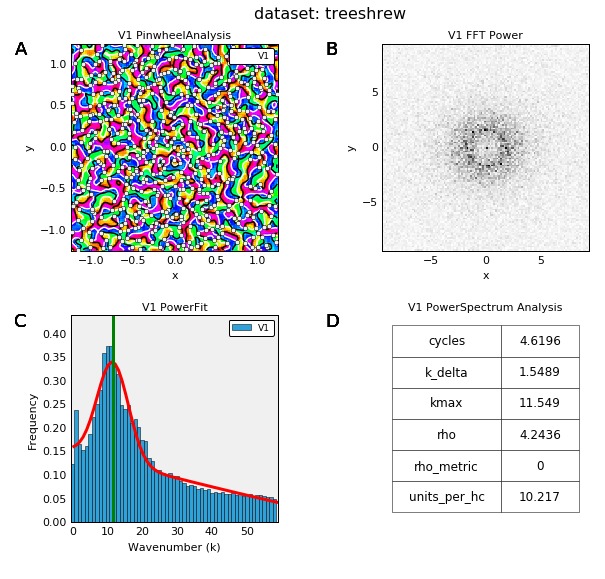

In [123]:
orpref = data.OrientationPreference.V1.select(time=20000)().select(x=(-1.25, 1.25), y=(-1.25, 1.25))
PowerSpectrumAnalysis(orpref.reindex(['dataset'])).map(lambda x: x.reindex(['dataset']), [hv.HoloMap]).display('all').cols(2)

## DoG Size Tuning Fits

In [239]:
ds = 'Gaussian'

In [242]:
size_response = data.SizeResponse.V1()
orpref = data.OrientationPreference.V1.select(time=20000)()
grouped_responses = size_response.groupby(['X', 'Y'])
fitted_curves = hv.HoloMap(kdims=['X', 'Y', 'Dataset', 'Contrast', 'x', 'y'])
for (X, Y), hmap in grouped_responses.items():
    curves = hmap.reindex().sample((10, 10), bounds=(X-.1, Y-.1, X+.1, Y+.1)).to.curve('Size', 'Response')
    for (contrast, x, y), curve in curves.items():
        measured_or = orpref.select(dataset=ds).last[X, Y]
        cell_or = orpref.select(dataset=ds).last[x, y]
        if circular_dist(measured_or, cell_or, np.pi) < np.pi/16.:
            fitted_curves[X, Y, ds, contrast, x, y] = Size_iDoGModel(curve)
v1_dog_fits = fitted_curves.collate()

In [243]:
v1_dog_table = v1_dog_fits.ItemTable.IDoG_Model_Fit.table()
df = v1_dog_table.dframe()
good_fits = df[(df['$r^2$']>0.8)]# & (df.Dataset=='Gaussian')]
grouped_fits = good_fits.groupby(['X', 'Y', 'Dataset', 'x', 'y'])

def filter_fn(x):
    contrasts = list(x.Contrast)
    return 30 in contrasts and 70 in contrasts

good_fit_table = v1_dog_table.clone(grouped_fits.filter(filter_fn))

In [244]:
def logx(plot, element):
    ax = plot.handles['axis']
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.tick_params('both', length=4, width=0.5, which='minor')
    ax.tick_params('both', length=8, width=0.5, which='major')
    ax.xaxis.set_ticks([0.01, 0.1, 1, 10])
    ax.xaxis.set_ticklabels([0.01, 0.1, 1, 10])
    ax.yaxis.set_ticks([0.01, 0.1, 1, 10])
    ax.yaxis.set_ticklabels([0.01, 0.1, 1, 10])
    ax.set_aspect(1)
    ax.set_ylim([0.1, 10])
    ax.set_xlim([0.1, 10])

In [251]:
%%output fig='svg' filename='SCAL_V1_DoG_Contrast'
%%opts Path [fontsize=dict(labels=20)] (color='k' linestyle='--' linewidth=0.8)
%%opts Overlay [bgcolor='w' show_frame=False] Points (color='none' edgecolor='k' s=25) []
%%opts Histogram (facecolor='w' edgecolor='k') [yaxis=None fontsize=dict(labels=20)] 
%%opts VLine (color='k' linewidth=2 linestyle='--') Overlay [bgcolor='w' show_frame=False]
low = good_fit_table.select(Contrast=30).data.copy()
high = good_fit_table.select(Contrast=70).data.copy()
css_table = hv.Table([(k, v['a'].iloc[0]/v['a'].iloc[1]) for k, v in grouped_fits if len(v) > 1],
                     kdims=['X', 'Y', 'Dataset', 'x', 'y'], vdims=['$a_{low}/a_{high}$'])

((hv.Path([[(0,0), (10, 10)]], kdims=['$a_{low}$', '$a_{high}$']) *\
hv.Points((high.a, low.a)))(plot=dict(final_hooks=[logx])) +\
css_table.hist('$a_{low}/a_{high}$', adjoin=False, bin_range=(0, 5), num_bins=11) *\
hv.Text(3.5, 0.4, '$\overline{CSS} = %.4g$' % css_table['$a_{low}/a_{high}$'].mean()) *\
hv.VLine(1)).cols(2)

:Layout
   .Overlay.I  :Overlay
      .Path.I   :Path   [$a_{low}$,$a_{high}$]
      .Points.I :Points   [x,y]
   .Overlay.II :Overlay
      .Histogram.I :Histogram   [$a_{low}/a_{high}$]   (Frequency)
      .Text.I      :Text   [x,y]
      .VLine.I     :VLine   [x,y]

:Layout
   .BoxWhisker.I  :BoxWhisker   [Contrast]   (a)
   .BoxWhisker.II :BoxWhisker   [Contrast]   (b)
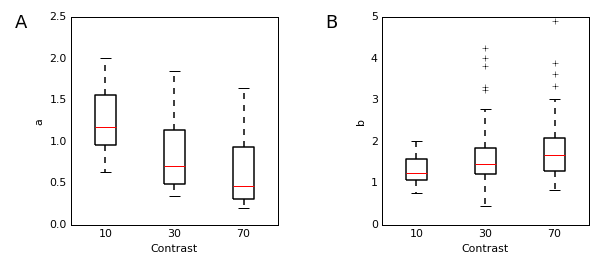

In [246]:
%%opts BoxWhisker [bgcolor='w']
good_fit_table.select(a=(0, 5), b=(0, 5)).to.box(['Contrast'], 'a', []) +\
good_fit_table.select(a=(0, 5), b=(0, 5)).to.box(['Contrast'], 'b', [])

In [247]:
%%output size=150 dpi=300 fig='svg' filename='V1_DoG_Distribution'
%%opts Histogram (edgecolor='k' facecolor='white') [fontsize={'xlabel':15, 'ticks':14}] {+axiswise}
%%opts Overlay [yaxis=None show_frame=False aspect=2 bgcolor='none' title_format='']
%%opts Layout [sublabel_position=(-0.15, 0.85) aspect_weight=1 sublabel_format='' hspace=0.3 vspace=0.4]

df = good_fit_table.select(Contrast=70).dframe()
df['a'] *= 3
df['b'] *= 3

peak_mean = df['a'].mean()
peak_median = df['a'].median()
surr_mean = df['b'].mean()
surr_median = df['b'].median()
peak_arrow = hv.Arrow(peak_median, 0, '', 'v')
surr_arrow = hv.Arrow(surr_median, 0, '', 'v')

size_tuning = (((hv.Table(df).hist(dimension='a', adjoin=False, num_bins=11)\
 .clone(kdims=[hv.Dimension('$r_c$', unit='$mm$')]) * peak_arrow).relabel('Size tuning center') *\
hv.Text(3, 0.5, '$n = %s$' % len(df), fontsize=16))(plot=dict(xticks=range(7))) +\
(hv.Table(df).hist(dimension='b', bin_range=(0, 10), adjoin=False, num_bins=11)\
 .clone(kdims=[hv.Dimension('$r_s$', unit='$mm$')]) * surr_arrow).relabel('Size tuning surround'))
size_tuning.cols(1)

:Layout
   .Overlay.I                    :Overlay
      .Histogram.I :Histogram   [$r_c$]   (Frequency)
      .Arrow.I     :Arrow   [x,y]
      .Text.I      :Text   [x,y]
   .Overlay.Size_tuning_surround :Overlay
      .Histogram.I :Histogram   [$r_s$]   (Frequency)
      .Arrow.I     :Arrow   [x,y]

## Suppression Index

In [15]:
import scipy.stats as ss

In [16]:
%%output dpi=120 size=120 fig='svg' filename='SCAL_V1_SI'
%%opts Overlay [aspect=1.5 show_frame=False bgcolor='none']
%%opts Histogram (edgecolor='k' facecolor='white') [fontsize={'xlabel':15, 'ticks':14} yaxis=None ]
import scipy.stats as ss
df = df[df.SI<1]
df = df[df.Contrast==70]
si_dist = (good_fit_table.select(Contrast=70).hist(dimension='SI', bin_range=(0, 1), adjoin=False).clone(extents=(0, None, 1.01, None), group='Suppression Index') *
           hv.Text(0.25, 2.5, '$\overline{SI}$: $%.3f \pm %.3f$' % (df.SI.mean(), ss.sem(df.SI)), fontsize=10))
si_dist

## Area summation/size tuning curves

In [101]:
sizeresponse = data.SizeResponse.V1()
size_curves = hv.GridSpace(kdims=['X', 'Y'])
for (x, y), responses in sizeresponse.groupby(['X', 'Y']).items():
    sampled = responses.sample((5, 5), bounds=(x-0.05, y-0.05, x+0.05, y+0.05))
    size_curves[x, y] = sampled.to.curve(['Size'], ['Response']).overlay('Contrast').grid(['x', 'y'])

:Layout
   .Size_Tuning.I  :HoloMap   [dataset,Time,Duration]
      :NdOverlay   [Contrast]
         :Curve   [Size]   (Response)
   .Size_Tuning.II :HoloMap   [dataset,Time,Duration]
      :NdOverlay   [Contrast]
         :Curve   [Size]   (Response)
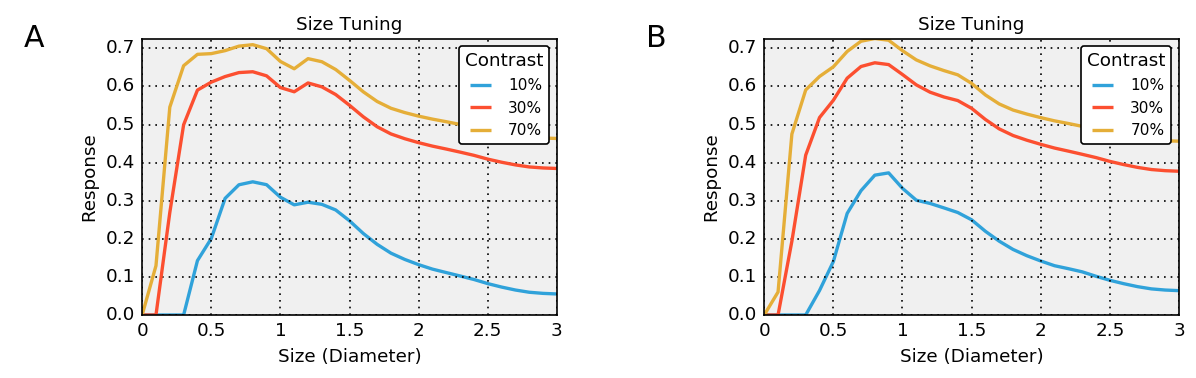

In [94]:
%%output dpi=120 size=120
%%opts NdOverlay [aspect=1.5] Layout [aspect_weight=0.5]
size_grid = size_curves[0,0].select(dataset='Gaussian')
size_grid[0.03, -.1].relabel(group='Size Tuning') + size_grid[0.01, -.14].relabel(group='Size Tuning')

### Orientation Tuning

:GridSpace   [x,y]
   :HoloMap   [dataset,Time,Duration]
      :NdOverlay   [Contrast]
         :Curve   [Orientation]   (Response)
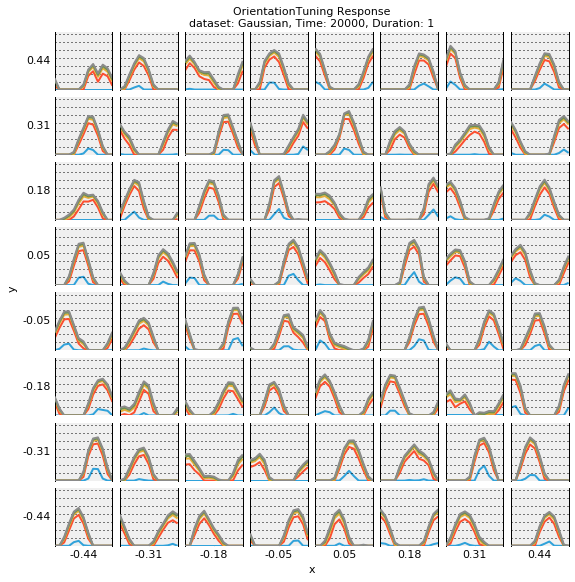

In [102]:
%%output size=150
%%opts NdOverlay [xaxis=None]
ortuning = data.OrientationTuning.V1()
ortuning_samples = ortuning.sample((8, 8), bounds=(-.5, -.5, .5, .5))
tuning_grid = ortuning_samples.to.curve('Orientation', 'Response').overlay('Contrast').grid(['x', 'y'])
tuning_grid

In [103]:
from featuremapper.analysis import center_cyclic
tuning_overlay = tuning_grid[-0.05, 0.05].select(dataset='Gaussian').last.map(center_cyclic, [hv.Curve])

normalized_tuning = tuning_overlay.clone(shared_data=False)
for key, curve in tuning_overlay.items():
    curve_data = curve.columns()
    max_r = curve.range('Response')[1]
    max_r = max_r if max_r else 1
    curve_data['Normalized Response'] = curve_data['Response']/max_r
    normalized_tuning[key] = curve.clone(curve_data, vdims=['Normalized Response'])

In [122]:
%%output fig='svg' filename='SCAL_V1_ORTuning'
%%opts NdOverlay [xaxis='bottom' bgcolor='none' show_frame=False legend_position='right' xticks=list(np.linspace(-np.pi/2, np.pi/2., 5))]
%%opts Curve (color=hv.core.options.Palette('gray', reverse=True)[:0.8])
%%opts Points (edgecolor='k' color='none' linewidth=1)
selection = dict(time=20000, dataset='Gaussian')
orpref = data.OrientationPreference.V1.select(**selection)()
orsel = data.OrientationSelectivity.V1.select(**selection)()
rfs = data.Retina_Reverse_Correlation.V1.select(**selection)()
rf_slice = rfs.clone({(x, y): rf.last[x-1.25:x+1.25, y-1.25: y+1.25] for (x, y), rf in rffit.RFGaborFit.RF_Fit[-.5:.5:4, -.5:.5:4].items()})
orpref.last[-1:1, -1:1] * hv.Points(rf_slice.keys()) + rf_slice + normalized_tuning

:Layout
   .Overlay.I                    :Overlay
      .Orientation_Preference.V1 :Image   [x,y]   (Orientation Preference)
      .Points.I                  :Points   [x,y]
   .RFs.V1                       :GridSpace   [X,Y]
      :Image   [x,y]   (Weight)
   .OrientationTuning_Response.I :NdOverlay   [Contrast]
      :Curve   [Orientation]   (Normalized Response)

In [191]:
%%output fig='svg' filename='SCAL_ORTuning'
%%opts Layout [sublabel_position=(-0.25, 0.85) hspace=0.25]
%%opts NdOverlay [aspect=1.5 xaxis='bottom' bgcolor='none' show_frame=False legend_position='right']
%%opts Curve (color=hv.core.options.Palette('gray', reverse=True)[:0.8])
tuning_overlay(plot=dict(show_legend=False)) + normalized_tuning

:Layout
   .OrientationTuning_Response.I  :NdOverlay   [Contrast]
      :Curve   [Orientation]   (Response)
   .OrientationTuning_Response.II :NdOverlay   [Contrast]
      :Curve   [Orientation]   (Normalized Response)

## Weight Distribution Plots

In [309]:
from topo.analysis import weights as weight_analysis
reload(weight_analysis)

<module 'topo.analysis.weights' from '/Users/philippjfr/topographica/topo/analysis/weights.py'>

662
644
719


:Layout
   .Orientation_Weight_Distribution.V1_LateralInhibitory :Histogram   [Orientation Difference]   (Weight)
   .Weight_Isotropy.V1_LateralInhibitory                 :Histogram   [Azimuth]   (Frequency)
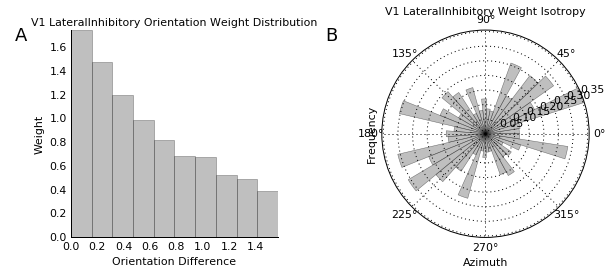

In [355]:
%%opts Histogram [bgcolor='none'] (facecolor='grey' alpha=0.5)

from topo.analysis.weights import WeightDistribution, WeightIsotropy

latinh = data.CFs.LateralInhibitory.select(time=20000)()
orpref = orpreference.OrientationPreference.V1
xpref = data.XPreference.V1.select(time=20000)()
ypref = data.YPreference.V1.select(time=20000)()

tree = hv.Layout()
tree.OrientationPreference.V1 = orpref.last
tree.XPreference.V1 = xpref.select(dataset='Gaussian').last
tree.YPreference.V1 = ypref.select(dataset='Gaussian').last
tree.CFs.LateralInhibitory = latinh.select(dataset='Gaussian', X=(-.5, .5), Y=(-.5, .5))

weight_orientation = weight_analysis.WeightDistribution(tree, projections=[('V1', 'LateralInhibitory')])
weight_isotropy = weight_analysis.WeightIsotropy(tree, projections=[('V1', 'LateralInhibitory')], num_bins=41)
weight_orientation.WeightDistribution.V1_LateralInhibitory.reindex(['dataset']).select(dataset='Gaussian')+\
weight_isotropy.WeightIsotropy.V1_LateralInhibitory.reindex(['dataset']).select(dataset='Gaussian')(plot=dict(projection='polar'))

In [357]:
%%output fig='svg' filename='SCAL_Inh_Distribution'
%%opts Histogram [aspect=1.5 bgcolor='none'] (edgecolor='k' facecolor='w') {-axiswise}
cross = weight_orientation.WeightDistribution.Cross_V1_LateralInhibitory.last
iso = weight_orientation.WeightDistribution.Iso_V1_LateralInhibitory.last
oblique = weight_orientation.WeightDistribution.Oblique_V1_LateralInhibitory.last
(iso + oblique + cross).map(lambda x: x.clone((x.data[0], x.data[1]*3000), kdims=[hv.Dimension('Distance', unit='$\mu m$')],
                                              extents=None, label=''), [hv.Histogram])

:Layout
   .Iso_hyphen_minus_Orientation_Weight_Distribution.V1_LateralInhibitory     :Histogram   [Distance]   (Weight)
   .Oblique_hyphen_minus_Orientation_Weight_Distribution.V1_LateralInhibitory :Histogram   [Distance]   (Weight)
   .Cross_hyphen_minus_Orientation_Weight_Distribution.V1_LateralInhibitory   :Histogram   [Distance]   (Weight)

## vonMises Weight Model

:NdOverlay   [k]
   :Curve   [x]   (y)
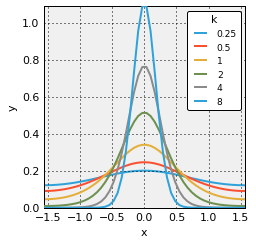

In [6]:
import analysis
hv.NdOverlay({k: hv.Curve([(i, analysis.vonMises_fn(i, k, 0)) for i in np.linspace(-np.pi/2., np.pi/2.)])
              for k in np.logspace(-2, 3, 6, base=2)}, kdims=['k'])

In [11]:
%output widgets='live'

In [13]:
reload(analysis)

<module 'analysis' from '/Users/philippjfr/topographica/analysis/__init__.py'>

In [15]:
orlhi = analysis.LocalHomogeneityIndex(orpreference.OrientationPreference.V1.last)
orsel = orpreference.OrientationSelectivity.V1 #data.OrientationSelectivity.V1.select(dataset='Gaussian', time=20000)()

if os.path.isfile('./SCAL_vonMises.hvz'):
    with open('SCAL_vonMises.hvz', 'rb') as f:
        vonMises = hv.Store.load(f)
    with open('SCAL_vonMises_aspect.hvz', 'rb') as f:
        vonMises_aspect = hv.Store.load(f)
else:
    tree = hv.Layout()

    central_cfs = orsel.clone({orsel.keys()[-1]: topo.sim.V1.LRExcitatory.grid(47, 47, lbrt=(-1, -1, 1, 1))}).collate()
    tree.CFs.LRExcitatory = central_cfs #.clone(zip(orsel.closest(central_cfs.keys()), central_cfs.values()))
    tree.OrientationPreference.V1 = orpreference.OrientationPreference.V1 #data.OrientationPreference.V1.select(time=20000, dataset='Gaussian')()

    vonMises = analysis.CFvonMisesFit(tree, sheet='V1', projection='LRExcitatory',
                             fit_aspect=False, threshold=70, max_iterations=10e3)

    vonMises_aspect = analysis.CFvonMisesFit(tree, sheet='V1', projection='LRExcitatory',
                                    fit_aspect=True, threshold=70, max_iterations=10e3)

    with open('SCAL_vonMises.hvz', 'wb') as f:
        hv.Store.dump(vonMises, f, 2)

    with open('SCAL_vonMises_aspect.hvz', 'wb') as f:
        hv.Store.dump(vonMises_aspect, f, 2)

vMa_df = vonMises_aspect.Results.Table.table().data
vMa_df['Model'] = [m+' w/ aspect' for m in vMa_df.Model]
vM_df = vonMises.Results.Table.table().data

vM_df['aspect'] = 1
combined = pd.concat([vM_df, vMa_df])
combined.x = np.round(np.array(combined.x), 6)
combined.y = np.round(np.array(combined.y), 6)
orsel_df = orsel.table().select(x=(-1, 1), y=(-1, 1)).dframe()
orsel_df.x = np.round(np.array(orsel_df.x), 6)
orsel_df.y = np.round(np.array(orsel_df.y), 6)
orlhi_df = orlhi.table().select(x=(-1, 1), y=(-1, 1)).dframe()
orlhi_df.x = np.round(np.array(orlhi_df.x), 6)
orlhi_df.y = np.round(np.array(orlhi_df.y), 6)
merged = combined.merge(orsel_df, on=['x', 'y']).merge(orlhi_df, on=['x', 'y'])
merged.rename(inplace=True, columns={'r2': '$R^2$', 'k': '$\kappa$'})
vM_dataset = hv.Dataset(merged, kdims=['Model', 'x', 'y'])

In [16]:
merged[merged['$R^2$'] == merged['$R^2$'].max()]

x         y Duration_x Time_x               Model           MSE  \
4574  0.053191  0.946809          1  20000  vonMises w/ aspect  5.910557e-09   

         $R^2$  $\kappa$       mu1       mu2   weight      xfit      yfit  \
4574  0.632269  0.646375  0.173166  0.040801  5.25894  0.063355  0.945774   

        aspect Time_y Duration_y  Orientation Selectivity       LHI  
4574  2.725658  20000          1                 1.713475  0.194667

In [65]:
%%output fig='svg' filename='SCAL_vonMises_Fits'
%%opts Layout [hspace=0.3 fig_inches=(12, 7) fig_bounds=(0.05, 0.05, 0.95, 0.95)] Histogram [yaxis='right']
%%opts Image [xaxis=None yaxis=None sublabel_position=(-.2, 0.85)]
%%opts Image.Fit (cmap='hot_r')
%%opts CFView [xaxis=None yaxis=None sublabel_position=(-.2, 0.85)] (cmap='hot_r')
%%opts Image.Error (cmap='RdBu_r') [symmetric=True] {-axiswise}

offset = 1.25
best_fit = merged[merged['$R^2$'] == merged['$R^2$'].max()]
match_fit = vM_dataset.select(x=float(best_fit['x']), y=float(best_fit['y']), Model='vonMises')

key = tuple(best_fit.iloc[0, 0:2])
slc = (slice(key[0]-offset, key[0]+offset), slice(key[1]-offset, key[1]+offset))

hv.plotting.mpl.ColorbarPlot.cbar_padding = 0.01
title_format = '{label} {group}\n $\kappa$: %.2f, M: %.2f %%, \n $\sigma_{{21}}$: %.2f $\mu m$, $\sigma_{{22}}$: %.2f $\mu m$'
fit_vals = (match_fit['$\kappa$'], (match_fit['weight']/(match_fit['weight']+1)*100).item(),
            match_fit['mu1']*3000, match_fit['mu2']*3000)
fit_title = title_format % fit_vals
aspect_fit_vals = (best_fit['$\kappa$'], (best_fit['weight']/(best_fit['weight']+1)*100).item(),
                   best_fit['aspect']*best_fit['mu1']*3000, best_fit['mu2']*3000)
aspect_fit_title = title_format % aspect_fit_vals

(vonMises.Preprocessed.CFs[key].last[slc].relabel(group='Model Weights') +\
 vonMises.VonMisesFit.CFs[key].last[slc].relabel(label='vonMises', group='Fit')(plot=dict(title_format=fit_title)) +\
 vonMises_aspect.VonMisesFit.CFs[key].last[slc].relabel(label='vonMises w/ aspect', group='Fit')(plot=dict(title_format=aspect_fit_title)) +\
 hv.Empty() +\
 vonMises.VonMisesFit.Error[key].last[slc].relabel(label='vonMises', group='Error') +\
 vonMises_aspect.VonMisesFit.Error[key].last[slc].relabel(label='vonMises w/ aspect', group='Error')(plot=dict(colorbar=True))).cols(3)

:Layout
   .Model_Weights.LRExcitatory   :CFView   [x,y]   (z)
   .Fit.VonMises                 :Image   [x,y]   (z)
   .Fit.VonMises_w_over_aspect   :Image   [x,y]   (z)
   .Empty.I                      :Empty
   .Error.VonMises               :Image   [x,y]   (Square Error)
   .Error.VonMises_w_over_aspect :Image   [x,y]   (Square Error)

In [18]:
from scipy.stats import spearmanr

In [24]:
%%output fig='svg' filename='SCAL_vonMises_ORSel'
%%opts Layout [fig_size=200]
%%opts Points (edgecolor='k' s=20 cmap='viridis') [bgcolor='none' fontsize=dict(ylabel=18) colorbar=True size_index=None color_index=2] 
%%opts Histogram (edgecolor='k' facecolor='w') [show_grid=False xaxis=None yaxis=None]
hv.plotting.mpl.SideHistogramPlot.border_size = 0
hv.plotting.mpl.SideHistogramPlot.offset = 0
hv.plotting.mpl.ColorbarPlot.cbar_padding = 0.2
vM_scatter = vM_dataset.select(**{'$R^2$': (0.3, None), 'Model': 'vonMises w/ aspect'}).to.points(['Orientation Selectivity', '$\kappa$'], ['$R^2$'], [])
corr, pval = spearmanr(vM_scatter['Orientation Selectivity'], vM_scatter['$\kappa$'])
spearman_label = 'spearman r=%.3f, p=%.3g' % (corr, pval)
(vM_scatter * hv.Text(0.6, 1.1, spearman_label)).hist(dimension=['Orientation Selectivity', '$\kappa$'])

:AdjointLayout
   :Histogram   [Orientation Selectivity]   (Frequency)
   :Overlay
      .Points.I :Points   [Orientation Selectivity,$\kappa$]   ($R^2$)
      .Text.I   :Text   [x,y]
   :Histogram   [$\kappa$]   (Frequency)

In [181]:
%%output fig='svg' filename='SCAL_Buzas_Distributions'
%%opts Distribution (kde_kws=dict(bw=0.2, cut=0) hist=True) [fontsize={'labels':18}] {+axiswise} 
%%opts Overlay [bgcolor='w' aspect=1.2 sublabel_position=(-0.3, 0.85)]
%%opts VLine (color='k') {+axiswise} Text {+axiswise} 
%%opts BoxWhisker [bgcolor='none' aspect=1.5 sublabel_position=(-0.2, 0.85) xrotation=20] 
%%opts Layout [aspect_weight=1 hspace=0.4 fig_size=150]
lat_fit_table = vM_dataset.select(Model='vonMises w/ aspect', mu1=(0, 10), **{'$R^2$': (0.3, None)})
txt = '$\sigma_{{{0}}} = {1:.5g} \mu m$'
mean_mu1 = np.mean(lat_fit_table.data.mu1*lat_fit_table.data.aspect*3000)
mean_mu2 = np.mean(lat_fit_table.data.mu2*3000)
hv.Distribution(lat_fit_table.data.mu2*3000,
                vdims=[hv.Dimension('$\sigma_{LOC}$', unit='$\mu m$')]) *\
hv.VLine(mean_mu2, extents=(0, None, 600, None)) *\
hv.Text(0.4, 7, txt.format('LOC', mean_mu2)) +\
hv.Distribution(lat_fit_table.data.mu1*3000*lat_fit_table.data.aspect,
                vdims=[hv.Dimension('$\sigma_{LR}$', unit='$\mu m$')]) *\
hv.VLine(mean_mu1, extents=(0, None, 3500, None)) *\
hv.Text(2.5, 2, txt.format('LR', mean_mu1)) +\
vM_dataset.to.box(['Model'], ['$R^2$'], [])

:Layout
   .Overlay.I    :Overlay
      .Distribution.I :Distribution   ($\sigma_{LOC}$)
      .VLine.I        :VLine   [x,y]
      .Text.I         :Text   [x,y]
   .Overlay.II   :Overlay
      .Distribution.I :Distribution   ($\sigma_{LR}$)
      .VLine.I        :VLine   [x,y]
      .Text.I         :Text   [x,y]
   .BoxWhisker.I :BoxWhisker   [Model]   ($R^2$)

# RF Tuning

In [81]:
rfs = data.Retina_Reverse_Correlation.V1.select(dataset='Gaussian')()
orpref = data.OrientationPreference.V1.select(Time=20000)()

In [82]:
rffit = RFGaborFit(rfs, orpref, roi_radius=1, max_iterations=10000)
fit_table = rffit.RFGaborFit.RF_Fit_Values.table()
fit_table.data['Time'] = fit_table.data.Time.astype(np.float)
fit_table.data['Duration'] = fit_table.data.Duration.astype(np.float)

/Users/philippjfr/miniconda/envs/science/lib/python2.7/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


:Layout
   .RFs.V1.I  :GridSpace   [X,Y]
      :HoloMap   [dataset,Time,Duration]
         :Image   [x,y]   (Weight)
   .RFs.V1.II :GridSpace   [X,Y]
      :HoloMap   [dataset,Time,Duration]
         :Image   [x,y]   (Weight)
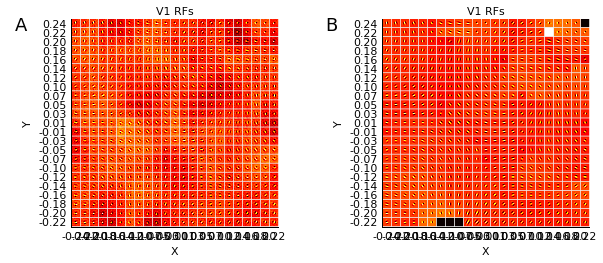

In [652]:
%%opts Image {+framewise +axiswise} GridSpace [normalize=True]
(rffit.RFGaborFit.RF_Normed + rffit.RFGaborFit.RF_Fit).cols(2).display('all')

:Layout
   .BoxWhisker.I   :BoxWhisker   [dataset]   (residual)
   .BoxWhisker.II  :BoxWhisker   [dataset]   (f)
   .BoxWhisker.III :BoxWhisker   [dataset]   (nx)
   .BoxWhisker.IV  :BoxWhisker   [dataset]   (ny)
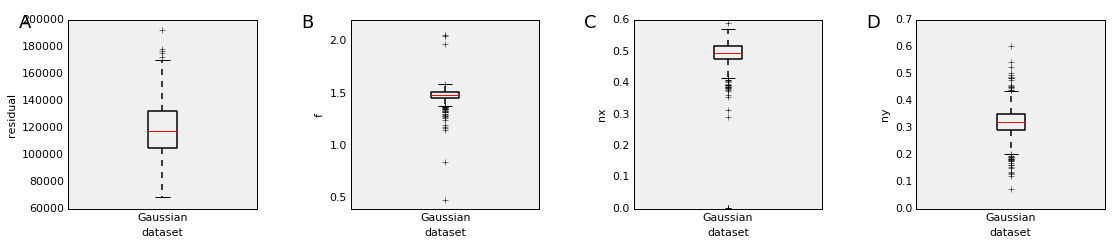

In [184]:
sliced = fit_table.select(f=(0,10), nx=(0, 2), ny=(0,2))
hv.Layout([sliced.to.box(['dataset'], [value], []) for value in ['residual', 'f', 'nx', 'ny']])

In [187]:
from holoviews.core.util import generator_types

In [797]:
%%output fig='svg' size=200 filename='RF_nxny'
%%opts RGB [fontsize={'labels':18}]
%%opts Scatter [show_grid=False] (edgecolor='k' s=50 linewidth=0.3 color='none') 
%%opts Overlay [bgcolor='w' legend_cols=1 show_frame=False] 
%%opts Path (color='k' linewidth=0.2) Image {+axiswise +framewise}

# Pick out RF at the top middle and bottom
rf_df = fit_table.data
max_ny_row = rf_df[rf_df.ny == rf_df.ny.max()]
max_ny = rffit.RFGaborFit.RF_Fit[tuple(max_ny_row.iloc[0, 0:5])]
low_ny_row = rf_df[(rf_df.ny < 0.2) & (rf_df.nx < 0.35)].sort_values('residual')
low_ny = rffit.RFGaborFit.RF_Fit[tuple(low_ny_row.iloc[0, 0:5])]
mid_ny_row = rf_df[(rf_df.nx > 0.5) & (rf_df.nx < 0.55) & (rf_df.ny > 0.3) & (rf_df.ny < 0.35)].sort_values('residual')
mid_ny = rffit.RFGaborFit.RF_Fit[tuple(mid_ny_row.iloc[0, 0:5])]

# Overlay experimental data with model data
hv.RGB.load_image('./Ringach_RFs.png', bounds=(0, 0, 1.5, 1.5), kdims=['$n_x$', '$n_y$']) *\
fit_table.to.scatter(['nx'], ['ny'], [], extents=(0, 0, 1.5, 1.5), label='SCAL')(style=dict(marker='s')) *\
hv.Scatter([(0,0)], label='Ringach et al. 2002 (macaque)')(style=dict(marker='o')) *\
hv.Scatter([(0,0)], label='Jones & Palmer 1987 (cat)')(style=dict(marker='x', color='k')) *\
low_ny.clone(bounds=(0.65, 0.2, 0.75, 0.3)) *\
hv.Path([[(low_ny_row.iloc[0]['nx'], low_ny_row.iloc[0]['ny']), (0.65, 0.2)]]) *\
mid_ny.clone(bounds=(0.7, 0.45, 0.8, 0.55)) *\
hv.Path([[(mid_ny_row.iloc[0]['nx'], mid_ny_row.iloc[0]['ny']), (0.7, 0.45)]]) *\
max_ny.clone(bounds=(0.8, 0.7, 0.9, 0.8)) *\
hv.Path([[(max_ny_row['nx'], max_ny_row['ny']), (0.8, 0.7)]])

:Overlay
   .RGB.I                                                                           :RGB   [$n_x$,$n_y$]   (R,G,B,A)
   .Scatter.SCAL                                                                    :Scatter   [nx]   (ny)
   .Scatter.Ringach_et_al_full_stop_2002_left_parenthesis_macaque_right_parenthesis :Scatter   [x]   (y)
   .Scatter.Jones_ampersand_Palmer_1987_left_parenthesis_cat_right_parenthesis      :Scatter   [x]   (y)
   .Receptive_Field.V1.I                                                            :Image   [x,y]   (Weight)
   .Path.I                                                                          :Path   [x,y]
   .Receptive_Field.V1.II                                                           :Image   [x,y]   (Weight)
   .Path.II                                                                         :Path   [x,y]
   .Receptive_Field.V1.III                                                          :Image   [x,y]   (Weight)
   .Path.III                                                                        :Path   [x,y]